# clusters of schools
https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

In [718]:
from importlib import reload
import houses.__main__
reload(houses.__main__)
from houses.__main__ import SchoolsStorage

In [719]:
storage = SchoolsStorage.init()

In [ ]:
import pandas as pd

In [ ]:
df =  pd.DataFrame(storage.iter_school_urn_to_coordinates("London"))
print(len(df))
df.head(3)

## One method to validate the number of clusters is the elbow method.

The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10), and for each value of k calculate the Sum of Squared Errors (SSE).

When K increases, the centroids are closer to the clusters centroids. The improvements will decline rapidly at some point, creating the elbow shape. That is the optimal value for K.

This might take a while.. stretch a little.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
def plot_elbow(k):
    k_clusters = range(1, k)
    kmeans = [KMeans(n_clusters=i) for i in k_clusters]
    y_axis = df[['latitude']]
    x_axis = df[['longitude']]
    score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]
    # Visualize
    plt.plot(k_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

In [ ]:
%time plot_elbow(40)

When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [ ]:
KMeans?

In [ ]:
def cluster_schools_by_location(*, dataframe, n_scools_in_cluster):
    kmeans = KMeans(n_clusters = int(len(dataframe) / n_scools_in_cluster), init ='random')
    coordinates = dataframe.columns[dataframe.columns.get_loc('latitude'):dataframe.columns.get_loc('longitude') + 1]
    kmeans.fit(dataframe[coordinates]) # Compute k-means clustering.
    dataframe['cluster_label'] = kmeans.fit_predict(dataframe[coordinates])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    labels = kmeans.predict(dataframe[coordinates]) # Labels of each point
    return centers, labels

In [ ]:
def get_cluster(*, dataframe, cluster_n):
    return dataframe[dataframe['cluster_label']==cluster_n]

## Visualise cluster

In [766]:
import folium
import itertools
import folium.vector_layers


def make_popup(school):
    ofsted_report = (
        'Absent report' 
        if not school.latest_ofsted["effectiveness"] 
        else f'{school.latest_ofsted["effectiveness"]} - {school.latest_ofsted["date"]}')
    return folium.Popup(max_width=450, html=f"""
<b>{school['schname']}</b> in {school['town']}
</br>
URN: {school['urn']}</br>
Postcode: {school['postcode']}</br>
Group: {school['minorgroup']}</br>
Type: {school['schooltype']}</br>
Age: {school['agelow']} - {school['agehigh']}</br>
<b>Ofsted</b>: {ofsted_report}
""")

RED_COLOUR = '#C30054'
GREY_COLOUR = '#525054'

MARKER_FILL_COLOUR_BY_SCHOOL_EFFECTIVENESS = {
    'Outstanding': 'green',
    'Good': 'blue',
    'Inadequate': 'red',
    'Requires improvement': 'yellow',
}

def make_marker(*, school: dict, circle_radius_meters=None) -> folium.Marker:
    marker_cls = folium.Circle if circle_radius_meters else folium.Marker
    effectiveness = school.latest_ofsted.get("effectiveness")
    colour = MARKER_FILL_COLOUR_BY_SCHOOL_EFFECTIVENESS.get(effectiveness, 'gray')
    attrs = dict(
        radius=circle_radius_meters,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
    ) if circle_radius_meters else {}
    return marker_cls(
        [school.latitude, school.longitude], 
        popup=make_popup(school), 
        tooltip=school.schname,
        icon=folium.Icon(color=colour, angle=25, icon='bookmark'),
        **attrs,
    )
    

def vis_schools(*, dataframe, cluster_n, radius_around_schl_meters=0):
    rows = dataframe.iterrows()
    idx, first = next(rows)
    m = folium.Map(location=[first['latitude'], first['longitude']],
                # tiles='Stamen Toner', 
                zoom_start=13)
    polygon_locations = []
    for idx, school in itertools.chain(((idx, first),), rows):
        make_marker(school=school, circle_radius_meters=radius_around_schl_meters).add_to(m)
        polygon_locations.append((school['latitude'], school['longitude']))
    # m.add_child(folium.ClickForMarker(popup='Interest'))
#     m.add_child(folium.vector_layers.Polygon(locations=polygon_locations))
    
    return m

def vis_cluster(*, dataframe, cluster_n):
    cluster = get_cluster(dataframe=dataframe, cluster_n=cluster_n)
    return cluster, vis_schools(dataframe=cluster, cluster_n=cluster_n)

In [764]:
def collect_and_vis(*, towns=None, boroughs=None, n_schools_in_cluster=3, radius_around_schl_meters=0, postcode_areas=(), agehigh=18, ignore_girls_school=True):
    all_schools_df =  pd.DataFrame(storage.iter_schools(towns=towns, boroughs=boroughs, postcode_areas=postcode_areas, agehigh=agehigh, ignore_girls_school=ignore_girls_school))
    print(f'Total schools found: {len(all_schools_df)}')
    if not len(all_schools_df):
        return None, None
    if len(all_schools_df) <= n_schools_in_cluster or n_schools_in_cluster == 1:
        filtered_by_min_schools_number = all_schools_df
    else:
        cluster_schools_by_location(dataframe=all_schools_df, n_scools_in_cluster=n_schools_in_cluster)
        print("N of clusters: " + str(max(all_schools_df.cluster_label.unique())))
        filtered_by_min_schools_number = all_schools_df.groupby('cluster_label').filter(
            lambda x: len(x) >= n_schools_in_cluster)

        print(f'After filtering clusters by min number ({n_schools_in_cluster}) of schools: '
              f'{len(filtered_by_min_schools_number.cluster_label.unique())} clusters left')
    return filtered_by_min_schools_number, vis_schools(dataframe=filtered_by_min_schools_number, cluster_n='all', radius_around_schl_meters=radius_around_schl_meters)

# Add properties

In [ ]:
import houses.zoopla
reload(houses.zoopla)
from houses.zoopla import ListedProperty
zoopla = houses.zoopla.get_client(token="jd74f2eeskshemzzdaxuzqhw")

In [757]:
def make_property_popup(listed: ListedProperty):
    floor_plan = '\n</br>'.join([
        f'<img src="{plan_img_url}" style="width: 50%; height: 50%"></img>'
        for plan_img_url in listed.floor_plan
    ]
    )
    return folium.Popup(max_width=950, max_height=950, html=f"""
    <a href="https://www.zoopla.co.uk/for-sale/details/{listed.listing_id}">Zoopla link</a>
</br>{listed.property_type} - {listed.num_bathrooms}bath - price{listed.price}
</br>
</br>Bedrooms: {listed.num_bedrooms}
</br><img src="{listed.image_80_60_url}"></img>
</br>{floor_plan}
""")
    

def make_property_marker(*, listed: ListedProperty) -> folium.Marker:
    return folium.Marker(
            [listed.latitude, listed.longitude], 
            popup=make_property_popup(listed), 
            tooltip=f'{listed.property_type} - {listed.num_bedrooms}beds - £{listed.price}',
            icon=folium.Icon(icon='home', color='darkblue'),
        )

def add_properties_to_map(*, zoopla_client, map, dataframe, radius_miles=0.5, maximum_price=400_000, min_beds=2):
    postcodes = dataframe.postcode.unique().tolist()
    print(f'Search properties for postcodes: {postcodes}')
    listings = [
        listing
        for postcode in postcodes
        for result in (zoopla_client.list_listings(
            postcode=postcode, 
            radius_miles=radius_miles, 
            maximum_price=maximum_price, 
            minimum_beds=min_beds),)
        for listing in result.listing
    ]
    print(f'Found {len(listings)} properties in listing')
    for l in listings:
        make_property_marker(listed=l).add_to(map)

# Explore specific boroughs
- Havering (ireland2011,india2011,nigeria2011;
- Barnet (india2011,poland2011,iran2011;
- Bexley (nigeria2011,india2011,
- Bromley (india2011,ireland2011,
- Camden (us2011,bangladesh2011,,
- Enfield (turkey2011,cyprus2011,
- Hammersmith and Fullham (france2011,ireland2011,
- Richmond upon Themes (ireland2011,southafrica2011,
- Haringey (poland2011,turkey2011,
- Islington (ireland2011,turkey2011,
- Kingston upon Thames (srilanka2011,india2011,
- Merton (poland2011,srilanka2011,
- Sutton (srilanka2011,india2011,
- Wandsworth (poland2011,southafrica2011,

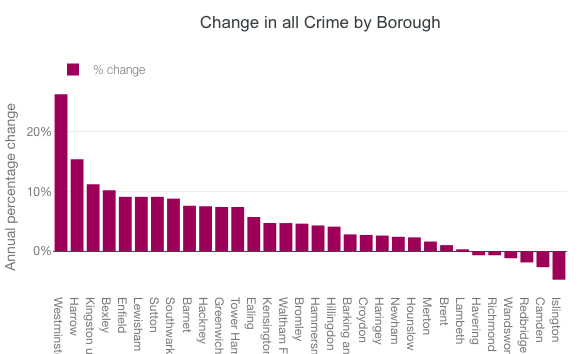

https://data.london.gov.uk/

In [ ]:
BOROUGHS_OF_INTEREST = (
    'Havering', 
    'Richmond upon Themes', 
    'Bromley',
    'Bexley',
    'Sutton',
    'Kingston upon Thames', 
    'Wandsworth',
    'Islington',
    'Hammersmith and Fullham'
    'Camden',
    'Merton',
    'Barnet',
    'Enfield',

                        , ,  
                        , 'Haringey',
                        , ,
                        
                        )

In [ ]:
from pathlib import Path
import enum

In [ ]:
atlas_path = Path('../data/london-borough-atlas.xlsx').absolute()
class AtlasSheet(enum.Enum):
    population = 'iadatasheet1'

In [ ]:

atlas_df_by_sheet_name = pd.read_excel(
    atlas_path, sheet_name=[AtlasSheet.population.value, ], 
    # use header 2 as if we use 0,1,2 it will create MultiIndex that's harder to operate with
    header=2)

In [ ]:
atlas_df_by_sheet_name[AtlasSheet.population.value].columns.tolist()

In [709]:
atlas_population = atlas_df_by_sheet_name[AtlasSheet.population.value]
area_of_interest = atlas_population#[atlas_population['Area name'].isin(BOROUGHS_OF_INTEREST)]
area_of_interest = area_of_interest[[
    'Area name',
    'Percentage BAME',
    # % of Secondary School Pupils who's first language is known or believed to be other than English
    2016,
    'Christian',
    'Muslim',
    'Largest migrant population by country of birth (Census 2011)',
    '% of largest migrant population (Census 2011)',
    'Second largest migrant population by country of birth (Census 2011)',
    '% of second largest migrant population (Census 2011)',
    # Largest migrant population arrived in the year
    '2015/16.1',
    # Second largest migrant population arrived in the year
    '2015/16.2',
#     'Third largest migrant population by country of birth (Census 2011)',
#     '% of third largest migrant population (Census 2011)',
    # % of borough total of largest migrant population
    '2015/16.4',
]].sort_values([
    'Percentage BAME',
    'Muslim',
    '% of largest migrant population (Census 2011)', 
                '% of second largest migrant population (Census 2011)', 
#                '% of third largest migrant population (Census 2011)'
])
area_of_interest

,Area name,Percentage BAME,2016,Christian,Muslim,Largest migrant population by country of birth (Census 2011),% of largest migrant population (Census 2011),Second largest migrant population by country of birth (Census 2011),% of second largest migrant population (Census 2011),2015/16.1,2015/16.2,2015/16.4
15,Havering,12.3,10.6,66,2,Ireland,1.1,India,1,Romania,Lithuania,45.0
26,Richmond upon Thames,14,19.4,58,3,Ireland,1.8,South Africa,1.4,Italy,Poland,10.1
36,England,14.6,15.7,57,6,India,1.3,Poland,1.1,Romania,Poland,22.5
5,Bromley,15.7,9.3,61,4,India,1.1,Ireland,1.1,Romania,Italy,19.1
3,Bexley,18.1,13.3,68,4,Nigeria,2.6,India,1.5,Romania,Poland,24.0
28,Sutton,21.4,22.2,52,7,Sri Lanka,1.8,India,1.7,Romania,Bulgaria,15.9
0,City of London,21.4,-,-,-,United States,2.8,France,2,India,France,10.7
20,Kingston upon Thames,25.5,30.5,58,9,Sri Lanka,2.2,India,1.8,Bulgaria,Romania,11.4
31,Wandsworth,28.6,45.3,48,9,Poland,2.2,South Africa,2.1,Italy,Spain,14.0
19,Kensington and Chelsea,29.4,50.9,55,13,United States,5,France,4.2,Italy,France,14.1


## Sutton

~200K population

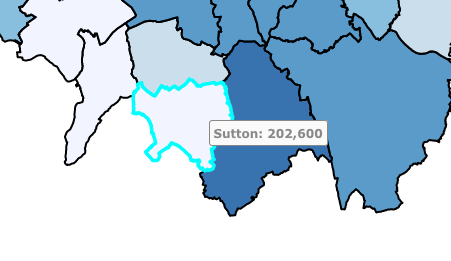


In [ ]:
clustered, map = collect_and_vis(agehigh=18, towns=('Sutton',), ignore_girls_school=False, n_schools_in_cluster=2)
add_properties_to_map(zoopla_client=zoopla, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

## Havering

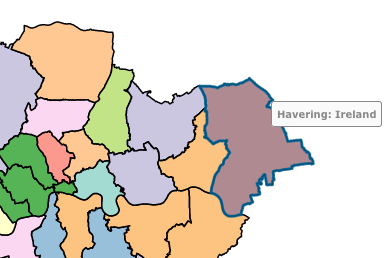

In [758]:
clustered, map = collect_and_vis(agehigh=18, boroughs=('Havering',), ignore_girls_school=False, n_schools_in_cluster=3)
add_properties_to_map(zoopla_client=zoopla, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '18'}}, {'laname': {'$in': ('Havering',)}}]
Total schools found: 8
N of clusters: 1
After filtering clusters by min number (3) of schools: 1 clusters left
Search properties for postcodes: ['RM14 2YQ', 'RM3 9XR', 'RM14 3HS', 'RM14 2QR', 'RM3 9YA', 'RM3 8HN']


<ipython-input-753-ef987d26e50a>:45: UserWarning: color argument of Icon should be one of: {'cadetblue', 'orange', 'white', 'lightred', 'blue', 'lightgray', 'green', 'lightgreen', 'gray', 'pink', 'purple', 'darkgreen', 'beige', 'black', 'darkred', 'lightblue', 'darkpurple', 'darkblue', 'red'}.
  icon=folium.Icon(color=colour, angle=15, icon='school'),


Found 32 properties in listing


## Islington

In [755]:
clustered, map = collect_and_vis(agehigh=18, boroughs=('Islington',), ignore_girls_school=False, n_schools_in_cluster=3)
add_properties_to_map(zoopla_client=zoopla, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '18'}}, {'laname': {'$in': ('Islington',)}}]
Total schools found: 12
N of clusters: 3
After filtering clusters by min number (3) of schools: 2 clusters left
Search properties for postcodes: ['N5 1AR', 'N1 8RE', 'N5 2EG', 'N7 8PG', 'N1 8PQ', 'N7 8LT', 'N1 2NQ', 'N1 0HY', 'N5 2EQ']


<ipython-input-753-ef987d26e50a>:45: UserWarning: color argument of Icon should be one of: {'cadetblue', 'orange', 'white', 'lightred', 'blue', 'lightgray', 'green', 'lightgreen', 'gray', 'pink', 'purple', 'darkgreen', 'beige', 'black', 'darkred', 'lightblue', 'darkpurple', 'darkblue', 'red'}.
  icon=folium.Icon(color=colour, angle=15, icon='school'),


Found 40 properties in listing


## Wandsworth

In [760]:
clustered, map = collect_and_vis(agehigh=18, boroughs=('Wandsworth',), ignore_girls_school=False, n_schools_in_cluster=1)
add_properties_to_map(zoopla_client=zoopla, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '18'}}, {'laname': {'$in': ('Wandsworth',)}}]
Total schools found: 22
N of clusters: 21
After filtering clusters by min number (1) of schools: 21 clusters left
Search properties for postcodes: ['SW15 5PY', 'SW11 1HS', 'SW15 6BH', 'SW12 8NA', 'CT10 1BY', 'SW15 5RT', 'SW18 3TB', 'SW11 1SH', 'SW15 2UT', 'SW11 3DQ', 'SW15 5JJ', 'SW12 8JZ', 'SW17 9BU', 'SW11 6BF', 'SW15 3DG', 'SW18 5JU', 'SW17 0AQ', 'SW11 5AP', 'SW18 5JR', 'SW17 0NY', 'SW19 6JB']


<ipython-input-500-d4bfc0445896>:4: ConvergenceWarning: Number of distinct clusters (21) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  kmeans.fit(dataframe[coordinates]) # Compute k-means clustering.
/Users/volodymyrvitvitskyi/Library/Caches/pypoetry/virtualenvs/houses-KnazE-Jj-py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1122: ConvergenceWarning: Number of distinct clusters (21) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


HTTPError: 403 Client Error: Forbidden for url: https://api.zoopla.co.uk/api/v1/property_listings.json?area=SW18+5JR&api_key=jd74f2eeskshemzzdaxuzqhw&listing_status=sale&maximum_price=400000&minimum_beds=2&radius=0.5

# Ealing

In [767]:
clustered, map = collect_and_vis(agehigh=18, boroughs=('Ealing',), ignore_girls_school=True, n_schools_in_cluster=3)
# add_properties_to_map(zoopla_client=zoopla, radius_miles=1, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'gender': {'$ne': 'Girls'}}, {'agehigh': {'$gte': '18'}}, {'laname': {'$in': ('Ealing',)}}]
Total schools found: 25
N of clusters: 7
After filtering clusters by min number (3) of schools: 5 clusters left
